## Transfer learning

2018 showed us that language modelling is a good task to train powerfull text representations. There are two different approaches how to use this representations: **feature extraction** and **fine-tuning**.

  * One great example of feature extraction is ELMo ([allennlp tutorial](https://github.com/allenai/allennlp/blob/master/tutorials/how_to/elmo.md), [tf_hub example](https://tfhub.dev/google/elmo/2), [deeppavlov documentation](http://docs.deeppavlov.ai/en/master/apiref/models/embedders.html?highlight=elmo#deeppavlov.models.embedders.elmo_embedder.ELMoEmbedder))
  * One great example of fine-tuning is ULMfit - ([fastai lesson](https://course.fast.ai/videos/?lesson=4), [example notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb))

What should you do?

  * Apply ELMo to make named entity recognition system. You can use [CONLL 2003 dataset (en)](http://files.deeppavlov.ai/deeppavlov_data/conll2003_v2.tar.gz) or [Persons1000 dataset (ru)](http://labinform.ru/pub/named_entities/descr_ne.htm) or any other dataset.
  * Apply ULMfit to make text classificator (any dataset, except IMDB)
  * Apply ELMo to make text classificator (on the same dataset)
  * Play with various models and hyperparameters
  * Compare results


**Results of this task:**
  * NER model
  * Two classification models
  * for each model:
    * metrics on the test set (quantitative evaluation)
    * succesfull and _unsucsessfull_ examples (qualitative evaluation)
    * plots showing that the model is training


**Additional points:**
  * Early stopping

In [1]:
# !pip install allennlp

# Name entity recognition with elmo

In [2]:
from allennlp.modules.elmo import Elmo, batch_to_ids

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Linear, Dropout
import torch.nn.functional as F

import numpy as np
from os.path import isfile, join
from typing import Union, List, Dict, Any
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


The dataset for named entity recognition will be CONLL 2003 dataset.

In [3]:
dataset_folder = 'conll2003_v2'

Data decription and example
The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Here is an example:

   U.N.         NNP  I-NP  I-ORG <br>
   official     NN   I-NP  O <br>
   Ekeus        NNP  I-NP  I-PER <br>
   heads        VBZ  I-VP  O <br>
   for          IN   I-PP  O <br>
   Baghdad      NNP  I-NP  I-LOC <br>

In [4]:
class EntityVocabulary:
        
    def __init__(self):
        self.vocabulary = []
        self.tag2i = {}
    
    def fit(self, data_files: List[str]):
        for path in data_files:
            assert(isfile(path))
        
        for path in data_files:
            with open(path, 'r') as f:
                for line in f:
                    if len(line.strip().split(' ')) < 3:
                        continue
                    tag = line.strip().split(' ')[3]
                    if tag not in self.vocabulary:
                        self.vocabulary.append(tag)
        
        self.tag2i = {tag: i for i, tag in enumerate(self.vocabulary)}
        return self
        
    def transform(self, tags: List[str]):
        try:
            transformed_tags = [self.tag2i[tag] for tag in tags]
        except KeyError:
            print('Tag: {} not in wocabulary'.format(tag))
        return transformed_tags
    
    def __len__(self):
        return len(self.vocabulary)

In [5]:
class CONLLDataset(Dataset):
    
    def __init__(self, path: str, tag_vocabulary):
        self.voc = tag_vocabulary
        self.texts, self.tags = self.read_data(path)
    
    def read_data(self, path: str):
        assert(isfile(path))
        texts, tags = [], []
        with open(path, 'r') as f:
            current_text, current_tags = [], []
            # skip beginnig info
            f.readline()
            f.readline()
            
            for line in f:
                data = line.strip().split(' ')
                if len(data) == 1:
                    texts.append(current_text)
                    tags.append(current_tags)
                    current_text, current_tags = [], []
                else:
                    current_text.append(data[0])
                    current_tags.append(data[3])
                    
        return texts, tags
                
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index: int):
        x = self.texts[index]
        y = torch.LongTensor(self.voc.transform(self.tags[index]))
        return x, y


In [6]:
tag_voc = EntityVocabulary()
tag_voc.fit([join(dataset_folder, file) for file in ['train.txt', 'valid.txt', 'test.txt']])
print(tag_voc.vocabulary)
print(tag_voc.transform(tag_voc.vocabulary))

['O', 'B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [7]:
train_dataset = CONLLDataset(join(dataset_folder, 'train.txt'), tag_voc)
val_dataset = CONLLDataset(join(dataset_folder, 'valid.txt'), tag_voc)
test_dataset = CONLLDataset(join(dataset_folder, 'test.txt'), tag_voc)

print(len(train_dataset), len(val_dataset), len(test_dataset))

14986 3465 3683


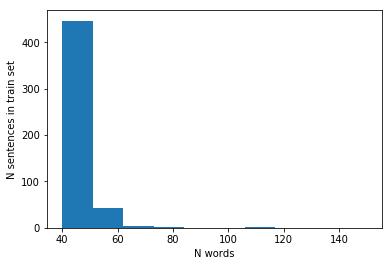

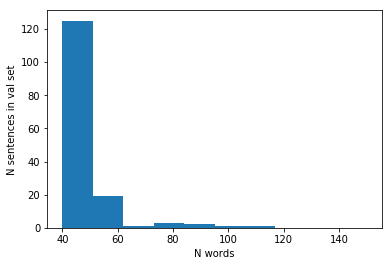

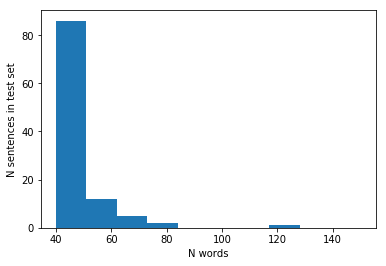

In [8]:
train_lengths = []
for x, _ in train_dataset:
    train_lengths.append(len(x))
    
val_lengths = []
for x, _ in val_dataset:
    val_lengths.append(len(x))
    
test_lengths = []
for x, _ in test_dataset:
    test_lengths.append(len(x))

plt.hist(train_lengths, range=(40, 150))
plt.ylabel('N sentences in train set')
plt.xlabel('N words')
plt.show();

plt.hist(val_lengths, range=(40, 150))
plt.ylabel('N sentences in val set')
plt.xlabel('N words')
plt.show();

plt.hist(test_lengths, range=(40, 150))
plt.ylabel('N sentences in test set')
plt.xlabel('N words')
plt.show();

In [9]:
def batch_sampler(batch: List[tuple], maxlen=60):
    
    sentences = [el[0][:maxlen] for el in batch]
    tags = [el[1][:maxlen] for el in batch]
    
    elmo_proc_sents = batch_to_ids(sentences)
    tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True)
    
    return elmo_proc_sents, tags

In [10]:
loader = DataLoader(test_dataset, 5, collate_fn=batch_sampler)

In [11]:
for x, y in loader:
    print(x.shape, y.shape)
    print(type(x), type(y))
    break

torch.Size([5, 25, 50]) torch.Size([5, 25])
<class 'torch.Tensor'> <class 'torch.Tensor'>


The task is to make dummy tagger from elmo

In [12]:
class ElmoTagger(Module):
    
    def __init__(self, vocab_size, elmo_options_file, elmo_weight_file, dropout=0.5, tune_elmo=False):
        super().__init__()
        self.elmo = Elmo(elmo_options_file, elmo_weight_file, 1, dropout=dropout, requires_grad=tune_elmo)
        self.dropout = Dropout(dropout)
        self.fc = Linear(1024, vocab_size)
        
    def forward(self, inputs):
#         print(inputs.shape)
        elmo = self.elmo(inputs)
        elmo = self.dropout(elmo['elmo_representations'][0])
#         print(elmo.shape)
        out = self.fc(elmo)
#         print(out.shape)
        
        return out

Model inplementation test

In [13]:
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

model = ElmoTagger(len(tag_voc), options_file, weight_file)

In [14]:
loader = DataLoader(val_dataset, 3, collate_fn=batch_sampler)
criterion = torch.nn.CrossEntropyLoss()

for x, y in loader:
    scores = model(x)
    print(torch.softmax(scores, dim=2))
    break

tensor([[[0.1018, 0.2418, 0.1476,  ..., 0.0828, 0.0635, 0.1558],
         [0.0859, 0.1137, 0.0830,  ..., 0.0788, 0.0953, 0.3147],
         [0.0760, 0.0595, 0.2072,  ..., 0.0862, 0.0371, 0.0741],
         ...,
         [0.1128, 0.1092, 0.1106,  ..., 0.1126, 0.1099, 0.1108],
         [0.1128, 0.1092, 0.1106,  ..., 0.1126, 0.1099, 0.1108],
         [0.1128, 0.1092, 0.1106,  ..., 0.1126, 0.1099, 0.1108]],

        [[0.1612, 0.1552, 0.1341,  ..., 0.1437, 0.0914, 0.1330],
         [0.2362, 0.0689, 0.0338,  ..., 0.0871, 0.0341, 0.3093],
         [0.1128, 0.1092, 0.1106,  ..., 0.1126, 0.1099, 0.1108],
         ...,
         [0.1128, 0.1092, 0.1106,  ..., 0.1126, 0.1099, 0.1108],
         [0.1128, 0.1092, 0.1106,  ..., 0.1126, 0.1099, 0.1108],
         [0.1128, 0.1092, 0.1106,  ..., 0.1126, 0.1099, 0.1108]],

        [[0.1956, 0.0470, 0.1898,  ..., 0.1029, 0.0703, 0.1164],
         [0.0809, 0.1839, 0.1882,  ..., 0.0637, 0.1274, 0.0389],
         [0.1383, 0.1067, 0.1735,  ..., 0.1238, 0.0548, 0.

Make train, eval functions

In [15]:
def accuracy(pred, y):
    pred_lbl = pred.argmax(dim=2)
    correct = (pred_lbl == y).float()
    acc = torch.mean(correct.sum(dim=1) / correct.shape[1])
    return acc

In [30]:
def train(model, loader, criterion, optimizer, device):
    model = model.to(device)
    model.train()
    
    epoch_loss, epoch_acc = 0, 0
    
    with tqdm_notebook(total=len(loader)) as pbar:
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            model.zero_grad()
            pred = model(x)
            loss = criterion(pred.permute(0,2,1), y)
            acc = accuracy(pred, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            pbar.update(1)
        
    return epoch_loss / len(loader), epoch_acc / len(loader)


def evaluate(model, loader, criterion, device):
    model.to(device)
    model.eval()
    
    epoch_loss, epoch_acc = 0, 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred.permute(0,2,1), y)
            acc = accuracy(pred, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [31]:
def save_model(model, optimizer, name, vocabulary):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_decription': str(model),
        'tag_vocab': vocabulary
    }, name)
    
def update_history(history, train_loss, train_acc, val_loss, val_acc):
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)    
    history['val_loss'].append(val_loss)    
    history['val_acc'].append(val_acc) 
    return history

Start learning

In [32]:
batch_size = 128
vocab_size = len(tag_voc)
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
epochs = 100

# model = ElmoTagger(vocab_size, options_file, weight_file, dropout=0.5)
# optim = torch.optim.Adam(model.parameters())
# criterion = torch.nn.CrossEntropyLoss()
# device = torch.device('cuda:1')

train_loader = DataLoader(train_dataset, batch_size, collate_fn=batch_sampler)
val_loader = DataLoader(val_dataset, batch_size, collate_fn=batch_sampler)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_loss = np.inf
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optim, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    if val_loss < best_loss:
        best_loss = val_loss
        save_model(model, optim, 'elmo_tagger.pt', tag_voc)
        
    history = update_history(history, train_loss, train_acc, val_loss, val_acc)
    
    print('{} | TRAIN loss: {:.4f}, acc: {:.4f}; VAL loss: {:.4f}, acc: {:.4f}'.
             format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


1 | TRAIN loss: 1.4010, acc: 0.9774; VAL loss: 1.3017, acc: 0.9878



2 | TRAIN loss: 1.2609, acc: 0.9800; VAL loss: 1.1705, acc: 0.9890



3 | TRAIN loss: 1.1336, acc: 0.9812; VAL loss: 1.0493, acc: 0.9897



4 | TRAIN loss: 1.0173, acc: 0.9815; VAL loss: 0.9373, acc: 0.9902



5 | TRAIN loss: 0.9104, acc: 0.9820; VAL loss: 0.8353, acc: 0.9902



6 | TRAIN loss: 0.8131, acc: 0.9824; VAL loss: 0.7427, acc: 0.9904



7 | TRAIN loss: 0.7260, acc: 0.9824; VAL loss: 0.6598, acc: 0.9904



8 | TRAIN loss: 0.6468, acc: 0.9827; VAL loss: 0.5860, acc: 0.9904



9 | TRAIN loss: 0.5777, acc: 0.9826; VAL loss: 0.5210, acc: 0.9906



10 | TRAIN loss: 0.5165, acc: 0.9827; VAL loss: 0.4640, acc: 0.9906



11 | TRAIN loss: 0.4631, acc: 0.9831; VAL loss: 0.4143, acc: 0.9905



12 | TRAIN loss: 0.4166, acc: 0.9830; VAL loss: 0.3708, acc: 0.9906



13 | TRAIN loss: 0.3756, acc: 0.9833; VAL loss: 0.3330, acc: 0.9905



14 | TRAIN loss: 0.3395, acc: 0.9835; VAL loss: 0.2998, acc: 0.9908



15 | TRAIN loss: 0.3083, acc: 0.9838; VAL loss: 0.2711, acc: 0.9908



16 | TRAIN loss: 0.2818, acc: 0.9838; VAL loss: 0.2461, acc: 0.9908



17 | TRAIN loss: 0.2581, acc: 0.9839; VAL loss: 0.2241, acc: 0.9908



18 | TRAIN loss: 0.2371, acc: 0.9841; VAL loss: 0.2049, acc: 0.9910



19 | TRAIN loss: 0.2194, acc: 0.9840; VAL loss: 0.1883, acc: 0.9908



20 | TRAIN loss: 0.2029, acc: 0.9842; VAL loss: 0.1733, acc: 0.9908



21 | TRAIN loss: 0.1890, acc: 0.9842; VAL loss: 0.1601, acc: 0.9909



22 | TRAIN loss: 0.1770, acc: 0.9842; VAL loss: 0.1485, acc: 0.9911



23 | TRAIN loss: 0.1646, acc: 0.9845; VAL loss: 0.1380, acc: 0.9910



24 | TRAIN loss: 0.1548, acc: 0.9846; VAL loss: 0.1286, acc: 0.9911



25 | TRAIN loss: 0.1458, acc: 0.9846; VAL loss: 0.1203, acc: 0.9910



26 | TRAIN loss: 0.1379, acc: 0.9847; VAL loss: 0.1129, acc: 0.9910



27 | TRAIN loss: 0.1310, acc: 0.9846; VAL loss: 0.1061, acc: 0.9912



28 | TRAIN loss: 0.1243, acc: 0.9847; VAL loss: 0.1001, acc: 0.9911



29 | TRAIN loss: 0.1182, acc: 0.9848; VAL loss: 0.0945, acc: 0.9911



30 | TRAIN loss: 0.1130, acc: 0.9848; VAL loss: 0.0895, acc: 0.9910



31 | TRAIN loss: 0.1079, acc: 0.9850; VAL loss: 0.0851, acc: 0.9911



32 | TRAIN loss: 0.1040, acc: 0.9849; VAL loss: 0.0810, acc: 0.9911



33 | TRAIN loss: 0.0995, acc: 0.9850; VAL loss: 0.0769, acc: 0.9912



34 | TRAIN loss: 0.0954, acc: 0.9850; VAL loss: 0.0736, acc: 0.9911



35 | TRAIN loss: 0.0922, acc: 0.9851; VAL loss: 0.0704, acc: 0.9912



36 | TRAIN loss: 0.0893, acc: 0.9850; VAL loss: 0.0674, acc: 0.9912



37 | TRAIN loss: 0.0860, acc: 0.9854; VAL loss: 0.0647, acc: 0.9913



38 | TRAIN loss: 0.0834, acc: 0.9853; VAL loss: 0.0621, acc: 0.9914



39 | TRAIN loss: 0.0807, acc: 0.9855; VAL loss: 0.0600, acc: 0.9912



40 | TRAIN loss: 0.0789, acc: 0.9853; VAL loss: 0.0579, acc: 0.9913



41 | TRAIN loss: 0.0769, acc: 0.9852; VAL loss: 0.0560, acc: 0.9911



42 | TRAIN loss: 0.0749, acc: 0.9855; VAL loss: 0.0543, acc: 0.9911



43 | TRAIN loss: 0.0730, acc: 0.9855; VAL loss: 0.0525, acc: 0.9913



44 | TRAIN loss: 0.0711, acc: 0.9855; VAL loss: 0.0508, acc: 0.9912



45 | TRAIN loss: 0.0697, acc: 0.9856; VAL loss: 0.0495, acc: 0.9911



46 | TRAIN loss: 0.0681, acc: 0.9857; VAL loss: 0.0480, acc: 0.9913



47 | TRAIN loss: 0.0671, acc: 0.9856; VAL loss: 0.0468, acc: 0.9912



48 | TRAIN loss: 0.0654, acc: 0.9855; VAL loss: 0.0455, acc: 0.9915



49 | TRAIN loss: 0.0639, acc: 0.9858; VAL loss: 0.0443, acc: 0.9915



50 | TRAIN loss: 0.0627, acc: 0.9860; VAL loss: 0.0434, acc: 0.9913



51 | TRAIN loss: 0.0620, acc: 0.9856; VAL loss: 0.0423, acc: 0.9913



52 | TRAIN loss: 0.0614, acc: 0.9856; VAL loss: 0.0415, acc: 0.9914



53 | TRAIN loss: 0.0601, acc: 0.9858; VAL loss: 0.0407, acc: 0.9914



54 | TRAIN loss: 0.0591, acc: 0.9859; VAL loss: 0.0398, acc: 0.9914



55 | TRAIN loss: 0.0586, acc: 0.9858; VAL loss: 0.0391, acc: 0.9914



56 | TRAIN loss: 0.0581, acc: 0.9857; VAL loss: 0.0385, acc: 0.9914



57 | TRAIN loss: 0.0572, acc: 0.9857; VAL loss: 0.0379, acc: 0.9914



58 | TRAIN loss: 0.0564, acc: 0.9858; VAL loss: 0.0374, acc: 0.9913



59 | TRAIN loss: 0.0561, acc: 0.9858; VAL loss: 0.0367, acc: 0.9914



60 | TRAIN loss: 0.0547, acc: 0.9860; VAL loss: 0.0361, acc: 0.9914



61 | TRAIN loss: 0.0542, acc: 0.9859; VAL loss: 0.0356, acc: 0.9913



62 | TRAIN loss: 0.0541, acc: 0.9861; VAL loss: 0.0351, acc: 0.9914



63 | TRAIN loss: 0.0535, acc: 0.9859; VAL loss: 0.0346, acc: 0.9915



64 | TRAIN loss: 0.0531, acc: 0.9859; VAL loss: 0.0343, acc: 0.9915



65 | TRAIN loss: 0.0525, acc: 0.9860; VAL loss: 0.0341, acc: 0.9914



66 | TRAIN loss: 0.0526, acc: 0.9859; VAL loss: 0.0335, acc: 0.9915



67 | TRAIN loss: 0.0517, acc: 0.9861; VAL loss: 0.0331, acc: 0.9916



68 | TRAIN loss: 0.0513, acc: 0.9860; VAL loss: 0.0329, acc: 0.9914



69 | TRAIN loss: 0.0514, acc: 0.9859; VAL loss: 0.0326, acc: 0.9915



70 | TRAIN loss: 0.0508, acc: 0.9860; VAL loss: 0.0323, acc: 0.9916



71 | TRAIN loss: 0.0506, acc: 0.9859; VAL loss: 0.0321, acc: 0.9915



72 | TRAIN loss: 0.0502, acc: 0.9861; VAL loss: 0.0319, acc: 0.9914



73 | TRAIN loss: 0.0503, acc: 0.9859; VAL loss: 0.0316, acc: 0.9915



74 | TRAIN loss: 0.0500, acc: 0.9859; VAL loss: 0.0315, acc: 0.9915



75 | TRAIN loss: 0.0493, acc: 0.9861; VAL loss: 0.0311, acc: 0.9916



76 | TRAIN loss: 0.0494, acc: 0.9859; VAL loss: 0.0310, acc: 0.9915



77 | TRAIN loss: 0.0492, acc: 0.9859; VAL loss: 0.0309, acc: 0.9915



78 | TRAIN loss: 0.0486, acc: 0.9860; VAL loss: 0.0305, acc: 0.9916



79 | TRAIN loss: 0.0488, acc: 0.9859; VAL loss: 0.0303, acc: 0.9916



80 | TRAIN loss: 0.0483, acc: 0.9861; VAL loss: 0.0303, acc: 0.9916



81 | TRAIN loss: 0.0486, acc: 0.9860; VAL loss: 0.0301, acc: 0.9915



82 | TRAIN loss: 0.0478, acc: 0.9862; VAL loss: 0.0300, acc: 0.9914



83 | TRAIN loss: 0.0478, acc: 0.9861; VAL loss: 0.0298, acc: 0.9915



84 | TRAIN loss: 0.0483, acc: 0.9862; VAL loss: 0.0297, acc: 0.9915



85 | TRAIN loss: 0.0480, acc: 0.9860; VAL loss: 0.0296, acc: 0.9915



86 | TRAIN loss: 0.0481, acc: 0.9858; VAL loss: 0.0297, acc: 0.9914



87 | TRAIN loss: 0.0475, acc: 0.9863; VAL loss: 0.0295, acc: 0.9914



88 | TRAIN loss: 0.0475, acc: 0.9862; VAL loss: 0.0293, acc: 0.9914



89 | TRAIN loss: 0.0469, acc: 0.9863; VAL loss: 0.0291, acc: 0.9916



90 | TRAIN loss: 0.0471, acc: 0.9861; VAL loss: 0.0292, acc: 0.9913



91 | TRAIN loss: 0.0472, acc: 0.9861; VAL loss: 0.0290, acc: 0.9914



92 | TRAIN loss: 0.0470, acc: 0.9861; VAL loss: 0.0288, acc: 0.9915



93 | TRAIN loss: 0.0473, acc: 0.9862; VAL loss: 0.0287, acc: 0.9916



94 | TRAIN loss: 0.0468, acc: 0.9862; VAL loss: 0.0288, acc: 0.9915



95 | TRAIN loss: 0.0468, acc: 0.9861; VAL loss: 0.0287, acc: 0.9916



96 | TRAIN loss: 0.0466, acc: 0.9862; VAL loss: 0.0286, acc: 0.9916



97 | TRAIN loss: 0.0464, acc: 0.9863; VAL loss: 0.0284, acc: 0.9917



98 | TRAIN loss: 0.0467, acc: 0.9862; VAL loss: 0.0283, acc: 0.9917



99 | TRAIN loss: 0.0472, acc: 0.9861; VAL loss: 0.0284, acc: 0.9917



100 | TRAIN loss: 0.0464, acc: 0.9862; VAL loss: 0.0282, acc: 0.9917


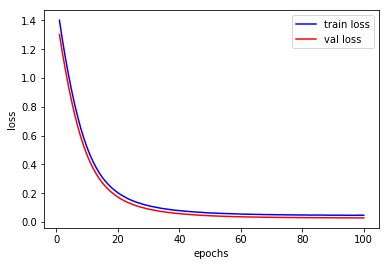

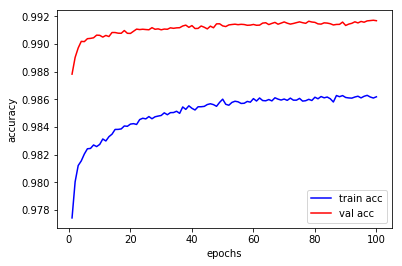

In [46]:
n_ep = [i+1 for i in range(len(history['train_loss']))]
plt.plot(n_ep, history['train_loss'], color='blue', label='train loss')
plt.plot(n_ep, history['val_loss'], color='red', label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(n_ep, history['train_acc'], color='blue', label='train acc')
plt.plot(n_ep, history['val_acc'], color='red', label='val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [47]:
torch.save({
    'history': history,
}, 'elmotagger.history')

In [48]:
# model loading

In [50]:
loader = DataLoader(test_dataset, 128, collate_fn=batch_sampler)

criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, loader, criterion, device)
print('Test loss {:.4f}, lest accuracy {:.4f}'.format(test_loss, test_acc))

Test loss 0.0313, lest accuracy 0.9903


# Text classifier from ULMFiT

In [2]:
# !pip install fastai

In [115]:
import pandas as pd

from fastai.text.data import TextLMDataBunch, TextClasDataBunch
from fastai.text import language_model_learner, AWD_LSTM, text_classifier_learner

from sklearn.model_selection import train_test_split
%matplotlib inline

Dataset is Twitter US Airline Sentiment. https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv

It containes tweets of tweets of airplane passengers. Each tweet has one of three labels: positive, negative, neutral

In [116]:
tweets_path = 'tweet_data/Tweets.csv'
tweets_df = pd.read_csv(tweets_path, usecols=['airline_sentiment', 'text'])
# tweets_df = tweets_df.reindex(columns=['text', 'airline_sentiment'])
tweets_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [117]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
airline_sentiment    14640 non-null object
text                 14640 non-null object
dtypes: object(2)
memory usage: 228.8+ KB


In [118]:
train_df, test_df = train_test_split(tweets_df, test_size=0.2, stratify=tweets_df['airline_sentiment'], random_state=42)
print(len(train_df), len(test_df))

11712 2928


In [119]:
train_df.to_csv('tweet_data/train.csv', index=False)
test_df.to_csv('tweet_data/test.csv', index=False)

In [120]:
pd.read_csv('tweet_data/train.csv').head()

,airline_sentiment,text
0,neutral,"@united good morning, any first class upgrades..."
1,neutral,@united's in-flight promo on their TV's includ...
2,negative,"@united no, it was 2 flight Cancelled Flightla..."
3,positive,@JetBlue it's been a while since I've angry tw...
4,negative,@AmericanAir narrowly made standby...lots of s...


In [121]:
data_lm = TextLMDataBunch.from_csv(path='tweet_data', csv_name='train.csv', valid_pct=0.1, max_vocab=5400)
data_lm.show_batch()

idx,text
0,bought your people told me it was xxmaj late xxmaj flight to do it . xxmaj so ... i want my things back xxbos @usairways xxmaj how soon is possible ? i boarded the plane the 1st time at 6:30 am and it is now after 11:30 am and i 'm still where i started . xxbos @usairways a tweeted apology is not enough for delay fiasco . xxup none
1,"to a human with some compassion ? i wrote an email to discuss my experience and received a generic "" sorry "" email back xxbos @americanair ok , i just received an email with my registration from your team . xxmaj thanks a lot xxbos @southwestair fyi the link in your baggage incident email xxunk to a 404 on mobile . xxmaj the link auto changes on mobile . xxmaj"
2,". xxbos @united every time i search a flight your site xxunk me out and gives error message . xxmaj about to book on a different airline and xxmaj cancelled xxmaj flight my card . xxbos @americanair thank you xxup aa , this is how i always start my vacations http : / / t.co / xxunk xxbos @usairways with a glass of wine once we hit altitude ? xxbos"
3,"xxmaj aspen , that 's why i 'm asking for standby on twitter . xxbos @jetblue xxmaj wish xxmaj everyone felt like you xxbos @southwestair yes please xxbos @usairways spoke with your reps in xxup nh and xxup pa . xxmaj very poor communications . xxmaj bags still sitting in xxmaj philly . xxup train xxup your xxup staff xxbos @united another week has passed and i hoped that i"
4,"am emailing xxunk in your company , maybe they will respond to me in a timely manner . xxbos @usairways traveling with 2 year old . would appreciate you holding up your end of good business and hosting us in our unanticipated layover . xxbos @americanair hour and a half after landing bags are finally xxunk off . http : / / t.co / xxunk xxbos @southwestair crew on flight"


In [122]:
data_lm.train_ds[0][0].data

array([   2,   21,   36, 2613,  228,   33,  148,   28,   41,  876])

In [123]:
data_lm.train_ds[0][0]

Text xxbos @united your overall experience of flying is not friendly

Fune-tuning the wikitext103 language model

In [124]:
bs=48

In [125]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [126]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


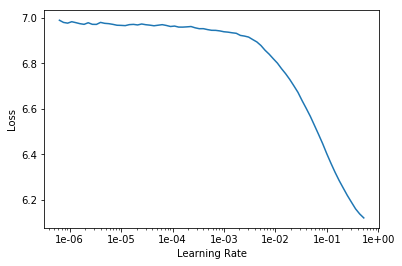

In [127]:
learn.recorder.plot(skip_end=15)

In [128]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.168137,4.252503,0.228635,00:06


In [129]:
learn.save('fit_head')

In [130]:
learn.load('fit_head');

In [131]:
learn.unfreeze()

In [132]:
learn.fit_one_cycle(7, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.243818,3.984752,0.262787,00:09
1,4.067544,3.834431,0.281569,00:09
2,3.889703,3.743132,0.291199,00:09
3,3.719847,3.700117,0.293591,00:09
4,3.568783,3.682697,0.297449,00:09
5,3.453050,3.679576,0.297864,00:09
6,3.387572,3.682815,0.297704,00:09


In [133]:
learn.save('fine_tuned')

In [134]:
learn.load('fine_tuned');

In [135]:
TEXT = "When I came to the airport"
N_WORDS = 40
N_SENTENCES = 2
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

When I came to the airport on an earlier flight that i had been on hold a plane was xxbos @united How do i get a refund of my $ 59 fee for a ticket ? Flight Booking Problems AUS

When I came to the airport you said i was responsible for the weather . No one was telling the gate i was in the airport trying to get home xxbos @southwestair i 'm sure you 're going to be ready at the gate !


In [136]:
learn.save_encoder('fine_tuned_enc')

Make classifier

In [137]:
data_clas = TextClasDataBunch.from_csv(path='tweet_data', csv_name='train.csv', valid_pct=0.1, max_vocab=5400)

In [138]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @americanair my wife was on a flt from xxup bro to xxup tul via xxup dfw that was xxmaj cancelled xxmaj flighted . xxmaj bought an xxup swa flight to get her home . xxmaj partial refund , xxup dm me plz ?",negative
"xxbos @jetblue big xxunk to the crews on xxunk xxmaj bos > jfk & & xxunk jfk > roc , & & gate crews at xxunk xxmaj bos & & 6 jfk . xxmaj long day of delays made better by them !",positive
xxbos @usairways i do n't think the xxup us site allows that ( unlike http : / / t.co / etfjqiwuvt ) . xxmaj can i use a xxup us credit if i held on http : / / t.co / etfjqiwuvt ?,neutral
"xxbos @jetblue xxmaj you just do n't get it . xxmaj it 's not about the money , xxmaj it 's about xxup people xxrep 4 ! xxmaj how about a public apology from the president of xxmaj jet xxmaj blue .",negative


In [139]:
len(data_lm.vocab.itos), len(data_clas.vocab.itos)

(5405, 5405)

In [140]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [141]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


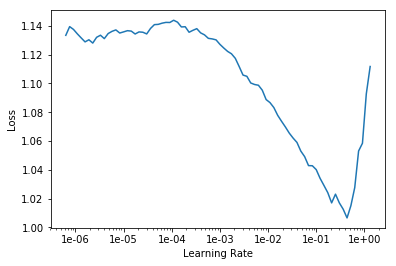

In [142]:
learn.recorder.plot()

In [143]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.788404,0.675885,0.720990,00:05


In [144]:
learn.save('first')

In [145]:
learn.load('first');

In [146]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.755344,0.618272,0.751706,00:05
1,0.679538,0.567792,0.767065,00:05
2,0.645033,0.555186,0.766212,00:06


In [147]:
learn.save('second')

In [148]:
learn.load('second');

In [149]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.614435,0.548008,0.777304,00:12
1,0.613308,0.541152,0.782423,00:12
2,0.616865,0.534124,0.785836,00:12
3,0.587339,0.521783,0.785836,00:12
4,0.571442,0.523663,0.784983,00:12
5,0.547330,0.518634,0.784983,00:12
6,0.528077,0.517440,0.783276,00:12
7,0.535864,0.519606,0.786689,00:12
8,0.526761,0.518668,0.787543,00:12
9,0.524765,0.515786,0.785836,00:12


In [150]:
true_pos, true_neg, true_neutral = [], [], []
for i in range(len(test_df)):
    text = test_df.iloc[i]['text']
    lbl = test_df.iloc[i]['airline_sentiment']
    pred_lbl = str(learn.predict(text)[0])
    if lbl == 'positive':
        if lbl in pred_lbl:
            true_pos.append(1)
        else:
            true_pos.append(0)
    elif lbl == 'negative':
        if lbl in pred_lbl:
            true_neg.append(1)
        else:
            true_neg.append(0)
    elif lbl == 'neutral':        
        if lbl == pred_lbl:
            true_neutral.append(1)
        else:
            true_neutral.append(0)


In [151]:
print('General acc: {:.4f}, pos acc: {:.4f}, neg acc: {:.4f}, neutral acc: {:.4f}'.format(
        (sum(true_pos) + sum(true_neg) + sum(true_neutral)) / len(test_df),
        sum(true_pos) / len(true_pos),
        sum(true_neg) / len(true_neg),
        sum(true_neutral) / len(true_neutral),))

General acc: 0.7777, pos acc: 0.6250, neg acc: 0.8851, neutral acc: 0.5758


# Text classifier from ELMO

In [112]:
from allennlp.modules.elmo import Elmo, batch_to_ids

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Dict, Any
from tqdm import tqdm_notebook
import re
from sklearn.model_selection import train_test_split

In [10]:
tweets = pd.read_csv('tweet_data/Tweets.csv', usecols=['airline_sentiment', 'text'])

In [11]:
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [54]:
class TweetsDataset(Dataset):
    
    def __init__(self, text_col_name:str, lbl_col_name:str, df=None, csv_path:str=None,  
                 use_columns:List[str]=None, split_pattern=None):
        if csv_path:
            self.df = pd.read_csv(csv_path, usecols=use_columns)
        if df is not None:
            self.df = df
        self.text_col = text_col_name
        self.lbl_col = lbl_col_name
        self.lbl2i = {lbl: i for i, lbl in enumerate(sorted(self.df[self.lbl_col].unique()))}
        self.tok_pattern = split_pattern if split_pattern else '(\W+)'
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = self._tokenize_text(self.df.iloc[index][self.text_col])
        y = self._transform_labels(self.df.iloc[index][self.lbl_col])
        return x, y
    
    def _transform_labels(self, label:str):
        return torch.tensor(self.lbl2i[label], dtype=torch.float32)
    
    def _tokenize_text(self, text:str):
        return [token for token in re.split(self.tok_pattern, text) if len(token.strip()) > 0]
    
def custom_collite(batch, maxlen=60):
    
    x = [i[0][:maxlen] for i in batch]
    y = [i[1] for i in batch]
    
    x = batch_to_ids(x)
    y = torch.LongTensor(y)
    return x, y

Dataset class test

In [55]:
tweet_path = 'tweet_data/Tweets.csv'
use_cols = ['airline_sentiment', 'text']
dataset = TweetsDataset(csv_path=tweet_path, text_col_name='text', lbl_col_name='airline_sentiment')

In [56]:
loader = DataLoader(dataset, 20, collate_fn=custom_collite)

for x, y in loader:
    print(x.shape, y.shape)
    break

torch.Size([20, 34, 50]) torch.Size([20])


Model

In [68]:
class ELMO_Classifier(Module):
    
    def __init__(self, n_classes, elmo_options_file, elmo_weights_file, n_filers, dropout=0.5):
        super().__init__()
        
        self.elmo = Elmo(elmo_options_file, elmo_weights_file, 1, dropout=dropout, requires_grad=False)
        self.conv3 = Conv1d(1024, n_filers, kernel_size=3, padding=1)
        self.conv5 = Conv1d(1024, n_filers, kernel_size=5, padding=2)
        self.fc = Linear(2*n_filers, n_classes)
        self.drop = Dropout(dropout)
        
    def forward(self, inputs):
        embeddings = self.elmo(inputs)
        embeddings = embeddings['elmo_representations'][0]
#         print(embeddings.shape)
        conv3 = torch.relu(self.conv3(embeddings.permute(0,2,1)))
        conv5 = torch.relu(self.conv5(embeddings.permute(0,2,1)))
#         print(conv3.shape)
#         print(conv5.shape)
        
        max_pool3 = F.max_pool1d(conv3, conv3.shape[2]).squeeze(2)
        max_pool5 = F.max_pool1d(conv5, conv5.shape[2]).squeeze(2)
#         print(max_pool3.shape)
#         print(max_pool5.shape)
        max_concat = torch.cat((max_pool3, max_pool5), dim=1)
#         print(max_concat.shape)
        scores = self.fc(self.drop(max_concat))
        return scores

Model implementation test

In [83]:
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

loader = DataLoader(dataset, 20, collate_fn=custom_collite)

model = ELMO_Classifier(3, options_file, weight_file, 512)

In [91]:
for x, y in loader:
    print('x,y', x.shape, y.shape)
    pred = model(x)
    print(pred.shape)
    acc = accuracy(pred, y)
    break

x,y torch.Size([20, 34, 50]) torch.Size([20])
torch.Size([20, 3])


Metrics function, train and eval functions

In [92]:
def accuracy(pred, y):
    pred_lbl = pred.argmax(dim=1)
    correct = (pred_lbl == y).float()
    acc = torch.mean(correct.sum(dim=0) / correct.shape[0])
    return acc

In [93]:
def train(model, loader, criterion, optimizer, device):
    model = model.to(device)
    model.train()
    
    epoch_loss, epoch_acc = 0, 0
    
    with tqdm_notebook(total=len(loader)) as pbar:
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            model.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            acc = accuracy(pred, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            pbar.update(1)
        
    return epoch_loss / len(loader), epoch_acc / len(loader)


def evaluate(model, loader, criterion, device):
    model.to(device)
    model.eval()
    
    epoch_loss, epoch_acc = 0, 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)
            acc = accuracy(pred, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [94]:
def save_model(model, optimizer, name, vocabulary):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_decription': str(model),
        'tag_vocab': vocabulary
    }, name)
    
def update_history(history, train_loss, train_acc, val_loss, val_acc):
    if 'train_loss' not in history:
        history['train_loss'] = []
    if 'train_acc' not in history:
        history['train_acc'] = []
    if 'val_loss' not in history:
        history['val_loss'] = []
    if 'val_acc' not in history:
        history['val_acc'] = []
        
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)    
    history['val_loss'].append(val_loss)    
    history['val_acc'].append(val_acc) 
    return history

Model training

In [154]:
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

n_filters = 1024
epochs = 100
b_s = 128
n_classes = 3
drop = 0.5

train_df = pd.read_csv('tweet_data/train.csv')
text_col, lbl_col = 'text', 'airline_sentiment'
train_df, val_df = train_test_split(train_df, stratify=train_df[lbl_col])

train_dataset = TweetsDataset(df=train_df, text_col_name=text_col, lbl_col_name=lbl_col)
val_dataset = TweetsDataset(df=val_df, text_col_name=text_col, lbl_col_name=lbl_col)

train_loader = DataLoader(train_dataset, b_s, collate_fn=custom_collite, num_workers=4)
val_loader = DataLoader(val_dataset, b_s, collate_fn=custom_collite, num_workers=4)

device = torch.device('cuda:1')

In [155]:
model = ELMO_Classifier(n_classes, options_file, weight_file, n_filters, drop)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

elmo_classifier_history = {}
best_loss = np.inf
for epoch in range(epochs):
    
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        if val_loss < best_loss:
            best_loss = val_loss
            save_model(model, optimizer, 'elmo_classifier.pt', train_dataset.lbl2i)
            
        update_history(elmo_classifier_history, train_loss, train_acc, val_loss, val_acc)
        
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.9
        
        print('{} | TRAIN loss: {:.4f}, acc: {:.4f}; VAL loss: {:.4f}, acc: {:.4f}'.
             format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


1 | TRAIN loss: 0.8222, acc: 0.7256; VAL loss: 0.5147, acc: 0.7990



2 | TRAIN loss: 0.4620, acc: 0.8144; VAL loss: 0.4674, acc: 0.8165



3 | TRAIN loss: 0.4142, acc: 0.8358; VAL loss: 0.4685, acc: 0.8175



4 | TRAIN loss: 0.3685, acc: 0.8577; VAL loss: 0.4636, acc: 0.8187



5 | TRAIN loss: 0.3179, acc: 0.8807; VAL loss: 0.5121, acc: 0.7927


KeyboardInterrupt: 

In [156]:
model.state_dict = torch.load('elmo_classifier.pt')['model_state_dict']

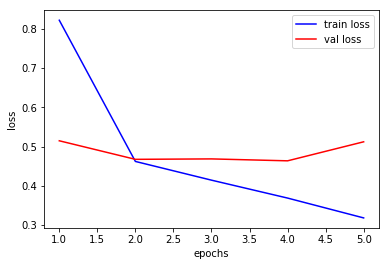

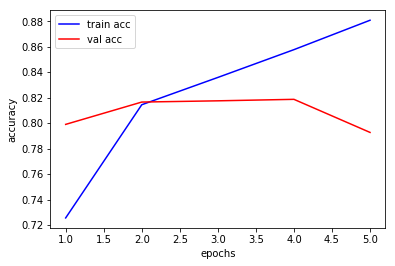

In [157]:
n_ep = [i+1 for i in range(len(elmo_classifier_history['train_loss']))]
plt.plot(n_ep, elmo_classifier_history['train_loss'], color='blue', label='train loss')
plt.plot(n_ep, elmo_classifier_history['val_loss'], color='red', label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(n_ep, elmo_classifier_history['train_acc'], color='blue', label='train acc')
plt.plot(n_ep, elmo_classifier_history['val_acc'], color='red', label='val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [158]:
test_df = pd.read_csv('tweet_data/test.csv')
test_dataset = TweetsDataset(df=test_df, text_col_name=text_col, lbl_col_name=lbl_col)
test_loader = DataLoader(test_dataset, 128, collate_fn=custom_collite, num_workers=4)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print('Test loss: {:.4f}, test acc: {:.4f}'.format(test_loss, test_acc))

Test loss: 0.4555, test acc: 0.8257


I was surprused but my elmo classifier got better results on Twitter US Airline Sentiment dataset than ULMFiT classifier: 0.826 (elmo + conv) vs 0.778 (ULMFiT) accuracy on test.

In [4]:
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, 1, dropout=0, requires_grad=False)

In [115]:
sentences = [['@VirginAmerica', 'What', '@dhepburn', 'said', '.'], ['Another', '.']]
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids, )

In [128]:
embeddings['elmo_representations']

[tensor([[[-0.2400, -0.1778, -0.0564,  ..., -0.1574,  0.1204, -0.0110],
          [ 0.1322,  0.0799,  0.0410,  ...,  0.0849, -0.0970,  0.2058],
          [-0.4073, -0.0794,  0.0103,  ...,  0.3389,  0.9941,  0.2901],
          [-0.1574,  0.1248,  0.3389,  ...,  0.2648,  0.1298,  0.6591],
          [-0.8448, -0.5905, -0.5819,  ..., -0.1007,  0.0352,  0.1065]],
 
         [[ 0.2690, -0.4020,  0.1042,  ..., -0.0860, -0.1631, -0.1533],
          [-0.7820, -0.4451, -0.3742,  ..., -0.0985,  0.0330,  0.1058],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
        grad_fn=<CopySlices>)]

In [ ]:
sentences = [['I', 'am', 'asf', 'asdf', 'dick'], ['🐽']]
character_ids = batch_to_ids(sentences)

In [ ]:
embeddings = elmo(character_ids)

In [ ]:
embeddings['elmo_representations'][0][0]

In [ ]:
embeddings['elmo_representations'][1][0]